# 0. Import library

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

# 1. Data

- Wikipeda에서 S&P500에 포함된 회사들의 리스트를 가져온다

In [2]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].tolist()      # Ticker 이름
security = data_table[0]['Security'].tolist()   #Ticker 이름에 해당하는 회사 전체 이름
sector = data_table[0]['GICS Sector'].tolist()

- 기간 (2017.01.01 ~ 2023.01.01) 내에 데이터 없는 Ticker 이름 지우기

In [3]:
unused_tickers = ['BRK.B', 'BF.B', 'KVUE', 'VLTO']
unused_security = []
unused_sector = []

for idx, ticker in enumerate(tickers):
    if ticker in unused_tickers:
        unused_security.append(security[idx])
        unused_sector.append(sector[idx])

for ticker_item, sector_item, security_item in zip(unused_tickers, unused_sector, unused_security):
    tickers.remove(ticker_item)
    sector.remove(sector_item)
    security.remove(security_item)

- 데이터 불러오기. (2017.01.01 ~ 2023.01.01)

In [4]:
prices_list = []    # 주가
risk_list = []      # 변동성
volume_list = []    # 거래량

In [5]:
for ticker in tqdm(tickers):
    data = yf.download(ticker, start='2017-01-01', end='2023-01-01', progress=False)

    # 주가 데이터
    prices = pd.DataFrame(data['Adj Close'])
    prices.columns = [ticker]
    prices_list.append(prices)

    # 거래량 데이터
    volume = pd.DataFrame(data['Volume'])
    volume.columns = [ticker]
    volume_list.append(volume)

    # 변동성 데이터 (리스크)
    returns = prices.pct_change().fillna(0)
    risk = returns.std().values[0]
    return_list.append(returns.mean().values[0])
    risk_list.append(risk)

100%|██████████| 499/499 [05:56<00:00,  1.40it/s]


In [14]:
# 주가
prices_df = pd.concat(prices_list,axis=1).pct_change().fillna(0) # 수익률 변화 계산
prices_df = prices_df.iloc[1:].T    # Ticker명을 Index로 사용
prices_df.sort_index(inplace=True)
normalize = Normalizer()            # 데이터 정규화
prices_df = pd.DataFrame(normalize.fit_transform(prices_df), columns=prices_df.columns, index=prices_df.index)

# 거래량
volume_df = pd.concat(volume_list,axis=1).fillna(0)
volume_df = volume_df.iloc[1:].T    # Ticker명을 Index로 사용
volume_df.sort_index(inplace=True)

# 변동성 (리스크)
risk_df = pd.DataFrame(risk_list, columns=['Risk'], index=tickers).fillna(0)
risk_df.sort_index(inplace=True)

# 평균수익률
return_df = pd.DataFrame(return_list, columns=['Returns'], index=tickers).fillna(0)
return_df.sort_index(inplace=True)

- 여러 feature 의 조합으로 데이터 프레임 생성하기

In [38]:
df_list = []
features = [prices_df, volume_df, risk_df]
feature_names = ['prices', 'volume', 'risk']  # 각 특성의 이름

# 가능한 모든 특성 조합에 대해 클러스터링 수행
for r in range(1, len(features) + 1):
    for feature_indices in combinations(range(len(features)), r):
        df = pd.concat([features[i] for i in feature_indices], axis=1)
        df.name = ' & '.join([feature_names[i] for i in feature_indices])  # 데이터프레임의 이름 생성
        df_list.append(df)

- 회사명 리스트와 값의 리스트를 저장한다.

In [16]:
companies = list(prices_df.index)
movements = prices_df.values

# 2. K means Clustering

In [39]:
# DELETE ME
import warnings

# FutureWarning 숨기기
warnings.simplefilter(action='ignore', category=FutureWarning)

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


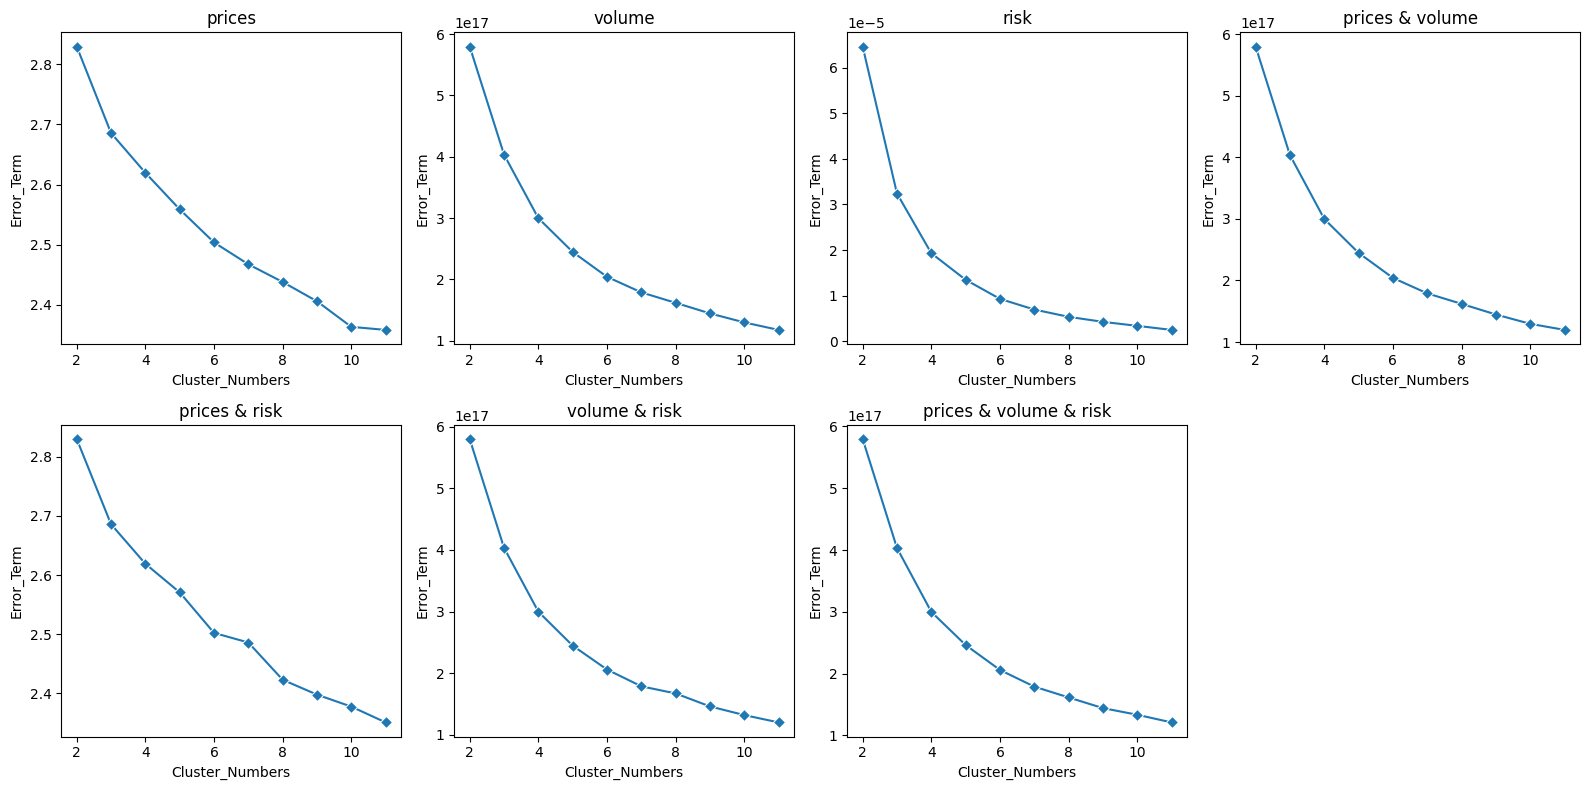

In [41]:
fig, axes = plt.subplots((len(df_list) + 3) // 4, 4, figsize=(16, 4 * ((len(df_list) + 3) // 4)))

for i, final_df in enumerate(df_list):
    final_df.columns = final_df.columns.astype(str) # 칼럼 이름의 타입 : str

    error = []
    for num_clusters in tqdm(num_of_clusters):
        clusters = KMeans(num_clusters)
        clusters.fit(final_df)
        error.append(clusters.inertia_ / 100)
    table = pd.DataFrame({"Cluster_Numbers": num_of_clusters, "Error_Term": error})
    table['DataFrame'] = final_df.name
    table.set_index(['DataFrame', 'Cluster_Numbers'], inplace=True)  # MultiIndex 설정

    sns.lineplot(data=table, x='Cluster_Numbers', y='Error_Term', marker="D", ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{final_df.name}')

for i in range(len(df_list), (len(df_list) + 3) // 4 * 4): # 빈 subplot은 숨기기
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

- 엘보우 방법으로 최적의 클러스터링 갯수를 찾는다.

In [42]:
elbow_points = []

for final_df in df_list:
    # Ensure column names are strings
    final_df.columns = final_df.columns.astype(str)

    sse = np.array(table.loc[final_df.name, 'Error_Term'])
    sse_diff = np.diff(sse)
    sse_diff2 = np.diff(sse_diff)

    min_length = len(sse) // 2
    elbow_point = np.argmax(sse_diff2[min_length:]) + min_length + 1
    elbow_points.append(elbow_point)

# 찾은 elbow points 중에서 가장 높은 값을 선택
max_elbow_point = max(elbow_points)

print(f'The maximum elbow point is at {max_elbow_point} clusters.')

KeyError: ignored

In [28]:
sse = np.array(table['Error_Term'])
sse_diff = np.diff(sse)                                           # SSE의 변화율 계산
sse_diff2 = np.diff(sse_diff)                                     # 변화율의 변화율 계산
min_length = len(sse) // 2                                        # (constraints) error term의 길이의 절반
elbow_point = np.argmax(sse_diff2[min_length:]) + min_length + 1  # 이계도함수가 가장 큰 지점 찾기 # 인덱스는 0부터 시작하므로 1을 더함
print(f'The elbow point is at {elbow_point} clusters.')

The elbow point is at 8 clusters.


- 최적의 클러스터링 개수만큼 클러스터를 만든다.

In [ ]:
clusters = KMeans(elbow_point)
clusters.fit(final_df)

In [ ]:
labels = clusters.predict(movements)

In [ ]:
print('labels : ',len(labels))
print('companies : ',len(companies))
print('security : ',len(security))
print('sector : ',len(sector))

In [ ]:
clustered_result = pd.DataFrame({'labels': labels, 'tickers': companies, 'full-name':security, 'sector':sector})
clustered_result.sort_values('labels')

In [ ]:
final_df['Cluster'] = clusters.labels_
final_df.head()

In [ ]:
final_df.tail()

# 3. Result

In [ ]:
plt.figure(figsize=(6,3))
sns.countplot(x = 'Cluster', data = final_df, palette = 'magma')
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)